In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import joblib

from sklearn.feature_selection import SelectKBest, f_classif
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/Users/suchithkurra/Desktop/Honey_Pot Research/data/combined.csv')


In [3]:
# Data preprocessing
# Drop any rows with missing values
data.dropna(inplace=True)

In [4]:
# Replace infinite or very large values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Drop rows containing NaN values
data.dropna(inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

In [8]:
# Split features and target variable
X = data.drop('Label', axis=1)
y = data['Label']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [10]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# SelectKBest with ANOVA F-value
k = 20  # Number of top features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [12]:
selected_features_indices = selector.get_support(indices=True)


In [13]:
selected_feature_names = X.columns[selected_features_indices]


In [14]:
# Print the selected feature names
print("Selected features:")
print(selected_feature_names)

Selected features:
Index([' Destination Port', 'Total Length of Fwd Packets',
       ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' URG Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Avg Bwd Segment Size', ' Subflow Fwd Bytes', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' min_seg_size_forward'],
      dtype='object')


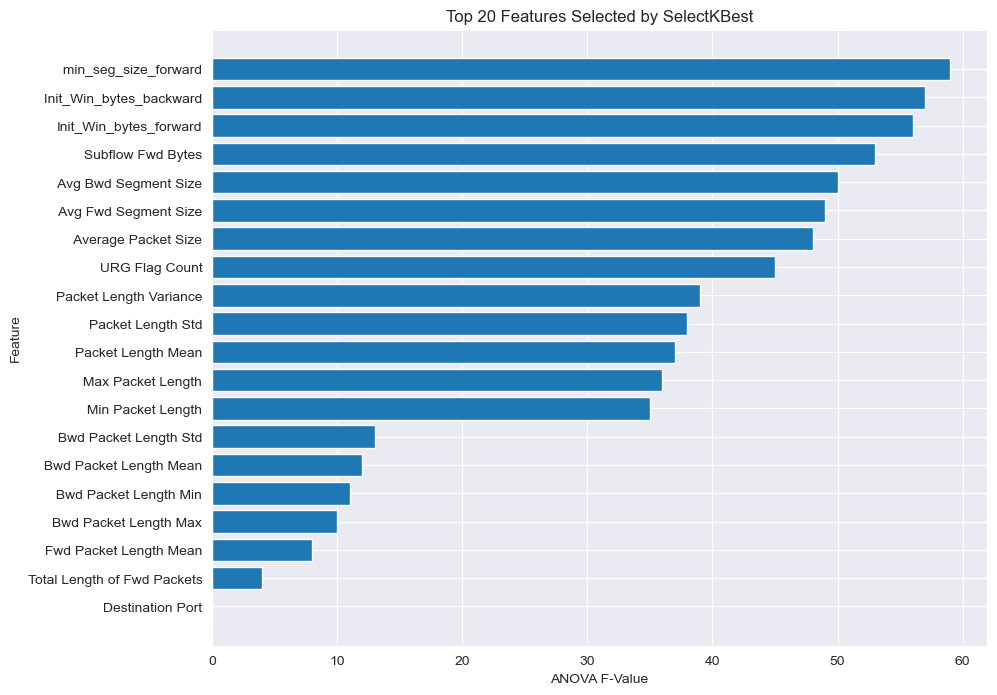

In [27]:
# Plot the selected feature scores
plt.figure(figsize=(10, 8))
plt.barh(selected_feature_names, selected_features_indices)
plt.xlabel('ANOVA F-Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest')
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [16]:
# Predictions
y_pred = rf_model.predict(X_test_selected)

In [17]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19661
           1       1.00      1.00      1.00     25466
           2       1.00      0.75      0.86        12
           3       1.00      1.00      1.00      2774
           4       0.94      0.99      0.96       439

    accuracy                           1.00     48352
   macro avg       0.99      0.95      0.96     48352
weighted avg       1.00      1.00      1.00     48352

Confusion Matrix:
[[19633     2     0     0    26]
 [    5 25461     0     0     0]
 [    3     0     9     0     0]
 [    0     0     0  2774     0]
 [    6     0     0     0   433]]


In [18]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_selected), multi_class='ovr')


In [19]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.999131369953673
Precision: 0.9991545889702533
F1 Score: 0.9991341490768032
ROC AUC Score: 0.9994723096591279


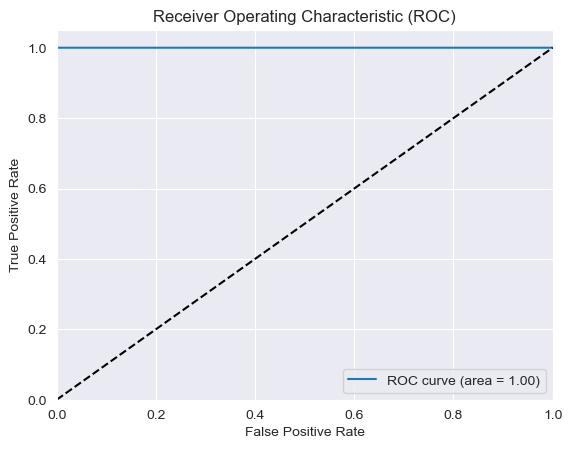

In [20]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test_selected)[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Confusion Matrix:
[[19633     2     0     0    26]
 [    5 25461     0     0     0]
 [    3     0     9     0     0]
 [    0     0     0  2774     0]
 [    6     0     0     0   433]]


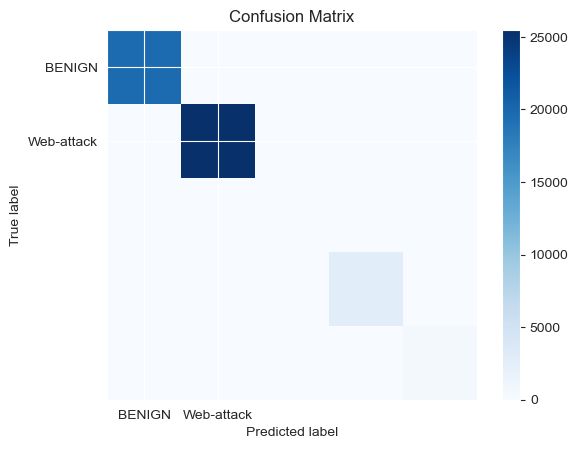

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks([0, 1], ['BENIGN', 'Web-attack'])
plt.yticks([0, 1], ['BENIGN', 'Web-attack'])
plt.show()

In [22]:
# Extracting false positives and false negatives from confusion matrix
FP = conf_matrix[0, 1]  # False positives: predicted DDoS, actual BENIGN
FN = conf_matrix[1, 0]  # False negatives: predicted BENIGN, actual DDoS

print("False Positives:", FP)
print("False Negatives:", FN)

False Positives: 2
False Negatives: 5


In [23]:
# Number of test values
num_test_values = len(y_test)
print("Number of test values:", num_test_values)

Number of test values: 48352


In [24]:
# Calculate percentage of false positives and false negatives
percentage = ((FP + FN) / num_test_values) * 100

print("Percentage of False Positives and False Negatives: {:.2f}%".format(percentage))

Percentage of False Positives and False Negatives: 0.01%


In [26]:
import joblib

# Save the trained model to a file
joblib.dump(rf_model, 'rf_combined_model.pkl')


['rf_combined_model.pkl']

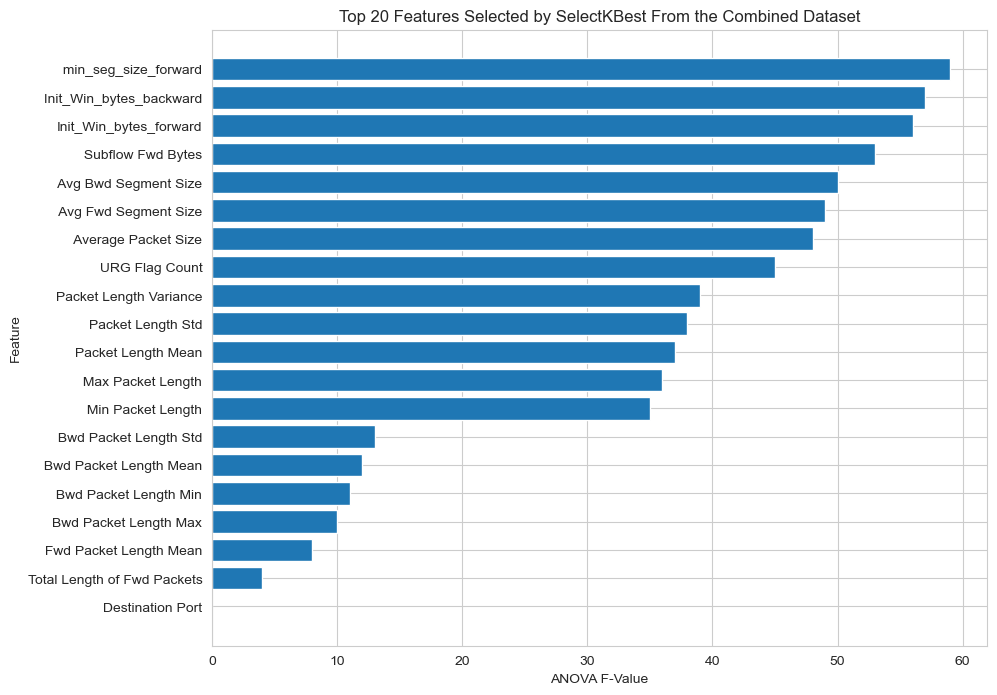

In [29]:
# Plot the selected feature scores
plt.figure(figsize=(10, 8))
plt.barh(selected_feature_names, selected_features_indices)

plt.xlabel('ANOVA F-Value')
plt.ylabel('Feature')
plt.title('Top 20 Features Selected by SelectKBest From the Combined Dataset')
plt.show()